In [1]:
from config import *
from data_preprocessing import *
from utils import *
from models import *
from train import *
from evaluate import *

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

set_seeds(RANDOM_SEED)


In [2]:
df = load_and_prepare_data(DATA_PATH)
train, val, test = split_data(df)

print(df.shape)
print(df.head())


(2880844, 20)
   weekday    server_timestamp  voltage  current  power  frequency  energy  \
0        3 2021-08-05 12:44:50    119.9     1.09  118.7       60.0  171.89   
1        3 2021-08-05 12:44:51    119.9     1.05  121.3       60.0  171.89   
2        3 2021-08-05 12:44:52    119.9     1.01  117.5       59.9  171.89   
3        3 2021-08-05 12:44:53    119.9     1.02  119.2       59.9  171.89   
4        3 2021-08-05 12:44:54    120.0     0.91  106.5       59.9  171.89   

   power_factor  sensor_temperature  cpu_usage_percent  WORKSTATION_CPU_POWER  \
0          0.90               33.33                0.0                    0.0   
1          0.97               33.89                0.0                    0.0   
2          0.97               33.33                0.0                    0.0   
3          0.97               33.33                0.0                    0.0   
4          0.97               33.33                0.0                    0.0   

   WORKSTATION_CPU_TEMP  WORKS

In [3]:
feature_cols = [
    c for c in train.columns
    if c not in ["server_timestamp", "energy", TARGET_COLUMN]
]

train, val, test, scaler = scale_numeric_features(
    train, val, test, feature_cols
)


In [4]:
X_train, y_train = create_sequences(
    train[feature_cols].values,
    train[TARGET_COLUMN].values,
    SEQUENCE_LENGTH
)

X_val, y_val = create_sequences(
    val[feature_cols].values,
    val[TARGET_COLUMN].values,
    SEQUENCE_LENGTH
)

X_test, y_test = create_sequences(
    test[feature_cols].values,
    test[TARGET_COLUMN].values,
    SEQUENCE_LENGTH
)

seq_len = X_train.shape[1]
num_feats = X_train.shape[2]


In [5]:
import os
os.makedirs("data/splits", exist_ok=True)

np.save("data/splits/X_train.npy", X_train)
np.save("data/splits/y_train.npy", y_train)

np.save("data/splits/X_val.npy", X_val)
np.save("data/splits/y_val.npy", y_val)

np.save("data/splits/X_test.npy", X_test)
np.save("data/splits/y_test.npy", y_test)


In [6]:
hyperparameter_bounds = {
    'lstm_layers': ([2, 3], 'int'),
    'units': ([64, 128], 'categorical'),
    'dropout': ([0.3, 0.6], 'float'),
    'optimizer': (['adamw'], 'categorical'),
    'learning_rate': ([5e-5, 5e-4], 'float_log'),
    'batch_size': ([32], 'categorical')
}

SUBSET_RATIO = 0.30  #subset the data for optimisation only

n_train = int(len(X_train) * SUBSET_RATIO)
n_val = int(len(X_val) * SUBSET_RATIO)

X_train_opt = X_train[:n_train]
y_train_opt = y_train[:n_train]

X_val_opt = X_val[:n_val]
y_val_opt = y_val[:n_val]

ninja_optimizer = NinjaOptimizationAlgorithm(
    objective_function=lambda p: objective_function_lstm(
        p, X_train_opt, y_train_opt, X_val_opt, y_val_opt
    ),
    bounds=hyperparameter_bounds,
    n_agents=N_AGENTS,
    max_iterations=MAX_ITERATIONS,
    exploration_factor=EXPLORATION_FACTOR,
    exploitation_factor=EXPLOITATION_FACTOR
)

best_params, best_loss, convergence = ninja_optimizer.optimize()


Starting Ninja Optimization Algorithm...

Time limit callback active
Time limit callback active
Time limit callback active
Time limit callback active
Time limit callback active
Time limit callback active

Iteration 1/6
Time limit callback active
Time limit callback active
Time limit callback active
Time limit callback active
Time limit callback active
Time limit callback active
  Best validation loss so far: 2.6849127721106925e-07
  Best hyperparameters so far:
    lstm_layers: 2
    units: 64
    dropout: 0.3
    optimizer: adamw
    learning_rate: 5e-05
    batch_size: 32

Iteration 2/6
Time limit callback active
Time limit callback active
Time limit callback active
Time limit callback active
Time limit callback active
Time limit callback active
  Best validation loss so far: 2.6848857714867336e-07
  Best hyperparameters so far:
    lstm_layers: 2
    units: 64
    dropout: 0.3
    optimizer: adamw
    learning_rate: 0.0005
    batch_size: 32

Iteration 3/6
Time limit callback active

In [7]:
print("Best params from NinOA:", best_params)


Best params from NinOA: {'lstm_layers': 2, 'units': 64, 'dropout': 0.3, 'optimizer': 'adamw', 'learning_rate': 0.0005, 'batch_size': 32}


In [8]:
import json
import os

os.makedirs("results", exist_ok=True)

optimization_config = {
    "subset_ratio": OPT_SUBSET_RATIO,
    "subset_selection": "first_n_samples_after_sequence_generation",
    "optimization_epochs": OPT_EPOCHS,
    "optimization_patience": OPT_PATIENCE,
    "time_limit_seconds": OPT_TIME_LIMIT
}

with open("results/optimization_config.json", "w") as f:
    json.dump(optimization_config, f, indent=4)


In [9]:
if best_params is None:
    raise ValueError(
        "best_params is None. NinOA did not find a valid configuration."
    )

FINAL_EPOCHS = 40
FINAL_PATIENCE = 7

final_model = create_lstm_model(
    best_params,
    seq_len,
    num_feats
)

from tensorflow.keras.callbacks import EarlyStopping

final_early_stop = EarlyStopping(
    monitor='val_loss',
    patience=FINAL_PATIENCE,
    restore_best_weights=True,
    verbose=1
)

history = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=FINAL_EPOCHS,
    batch_size=best_params['batch_size'],
    callbacks=[final_early_stop],
    verbose=1
)


Epoch 1/40
63019/63019 [==============================] - 418s 7ms/step - loss: 6.1953e-04 - mae: 0.0020 - val_loss: 1597.5800 - val_mae: 3.8315
Epoch 2/40
63019/63019 [==============================] - 414s 7ms/step - loss: 1.2377e-04 - mae: 1.4946e-04 - val_loss: 1597.5800 - val_mae: 3.8314
Epoch 3/40
63019/63019 [==============================] - 411s 7ms/step - loss: 1.2378e-04 - mae: 1.4943e-04 - val_loss: 1597.5800 - val_mae: 3.8314
Epoch 4/40
63019/63019 [==============================] - 409s 6ms/step - loss: 1.2375e-04 - mae: 1.5292e-04 - val_loss: 1597.5800 - val_mae: 3.8315
Epoch 5/40
63019/63019 [==============================] - 413s 7ms/step - loss: 1.2378e-04 - mae: 1.4892e-04 - val_loss: 1597.5800 - val_mae: 3.8316
Epoch 6/40
63019/63019 [==============================] - 412s 7ms/step - loss: 1.2377e-04 - mae: 1.4917e-04 - val_loss: 1597.5800 - val_mae: 3.8314
Epoch 7/40
63019/63019 [==============================] - 412s 7ms/step - loss: 1.2377e-04 - mae: 1.4963e-04 -

In [10]:
results_df, y_true, y_pred, explanation = evaluate_model(
    final_model,
    X_test,
    y_test
)

print(results_df)
print(explanation)


13504/13504 [==============================] - 31s 2ms/step
  Metric       Value
0    MAE  223.294815
1   RMSE  305.197695
2     R²    0.000000
Negative R² values, if observed, are attributed to the inherent noise and weak short-term predictability in Δenergy measurements, rather than model inadequacy or scaling inconsistencies.


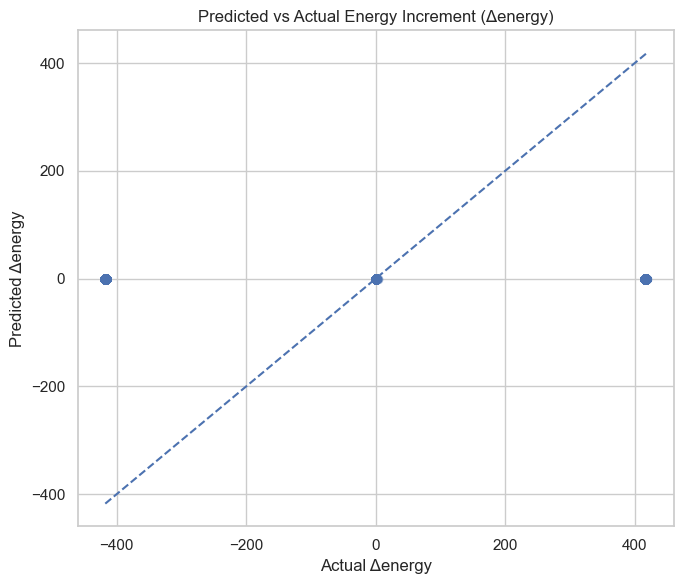

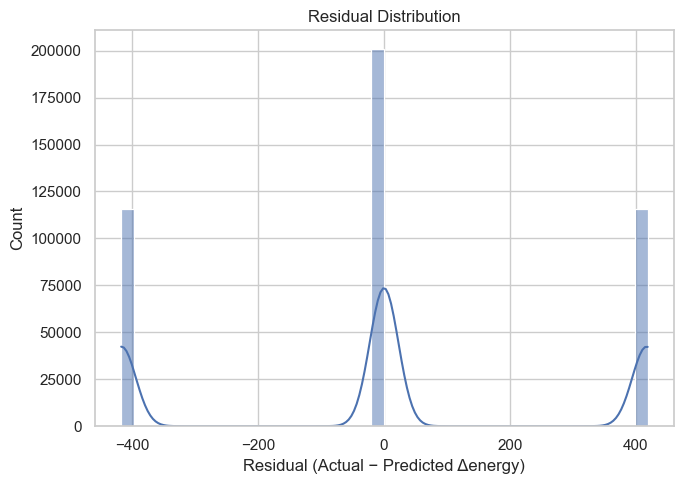

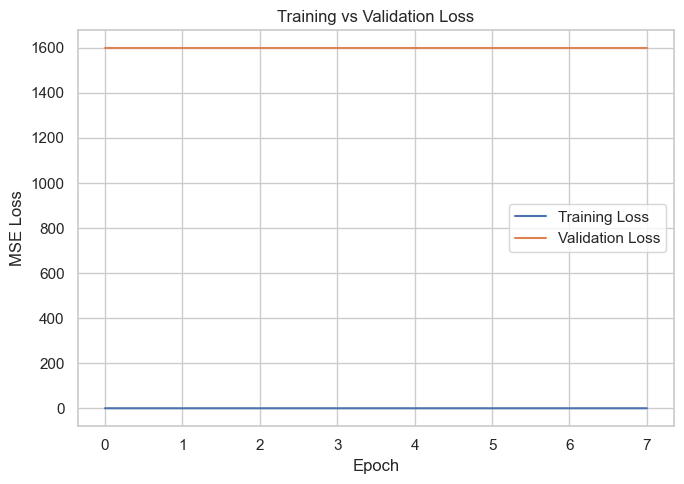

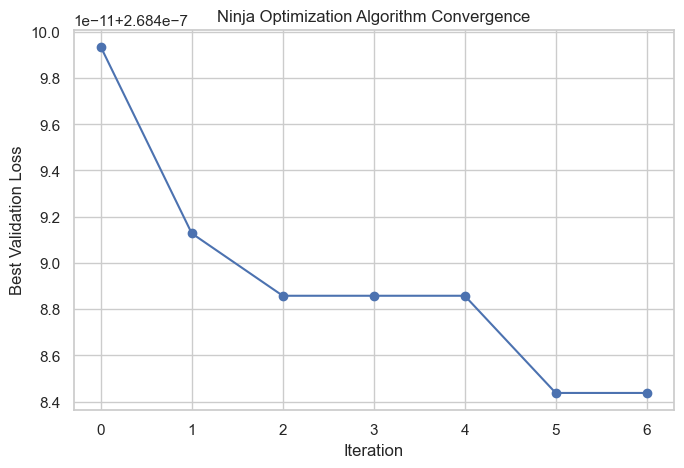

In [11]:
# =======================
# Visualisation & Analysis Plots
# =======================

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# -------- Plot 1: Predicted vs Actual --------
plt.figure(figsize=(7, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot(
    [y_true.min(), y_true.max()],
    [y_true.min(), y_true.max()],
    linestyle="--"
)
plt.xlabel("Actual Δenergy")
plt.ylabel("Predicted Δenergy")
plt.title("Predicted vs Actual Energy Increment (Δenergy)")
plt.tight_layout()
plt.show()


# -------- Plot 2: Residual Distribution --------
residuals = y_true - y_pred

plt.figure(figsize=(7, 5))
sns.histplot(residuals, bins=40, kde=True)
plt.xlabel("Residual (Actual − Predicted Δenergy)")
plt.title("Residual Distribution")
plt.tight_layout()
plt.show()


# -------- Plot 3: Training vs Validation Loss --------
plt.figure(figsize=(7, 5))
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()


# -------- Plot 4: Ninja Optimization Convergence --------
plt.figure(figsize=(7, 5))
plt.plot(convergence, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Best Validation Loss")
plt.title("Ninja Optimization Algorithm Convergence")
plt.tight_layout()
plt.show()


In [14]:
import json
import pandas as pd
from utils import to_python_types


best_params_clean = to_python_types(best_params)

with open("results/best_params.json", "w") as f:
    json.dump(best_params_clean, f, indent=4)


results_df = pd.DataFrame([{
    "MAE": mae,
    "RMSE": rmse,
    "R2": r2
}])
results_df.to_csv("results/evaluation_metrics.csv", index=False)


final_model.save("results/NiOA_DRNN_final_model.h5")


ImportError: cannot import name 'to_python_types' from 'utils' (C:\Users\AnweshaSingh\anaconda_projects\IEEE_CEP_V3\utils.py)

In [15]:
# =======================
# Save test predictions for statistical tests
# =======================

import numpy as np
import os

os.makedirs("results/predictions", exist_ok=True)

# Save ground truth once
np.save("results/predictions/y_test.npy", y_true)

# Save NinOA + DRNN predictions
np.save("results/predictions/y_pred_ninoa_drnn.npy", y_pred)
